In [108]:
# Modeling
import tensorflow as tf
import tensorboard
from tensorflow.keras import layers, Sequential

# Cleaning / regex / preprocessing
import string
import re
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_csv('../data/Emotion_final.csv')
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [109]:
le = LabelEncoder()


df['target'] = le.fit_transform(df['Emotion'])
df

,Text,Emotion,target
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1


In [110]:
df[df['target'] == 4]

,Text,Emotion,target
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
5,ive been feeling a little burdened lately wasn...,sadness,4
10,i feel like i have to make the suffering i m s...,sadness,4
13,i feel low energy i m just thirsty,sadness,4
...,...,...,...
20731,"The tears came , and rapidly dissolved her ang...",sadness,4
20732,Through a swell of tears Ruth stared incredulo...,sadness,4
20733,She glanced down at the linoleum in despai,sadness,4
20734,Perhaps it was despair that made me believe th...,sadness,4


In [111]:
df.isnull().sum()

Text       0
Emotion    0
target     0
dtype: int64

In [112]:
df[df['Text'] == '']

,Text,Emotion,target


<AxesSubplot:xlabel='target', ylabel='Count'>

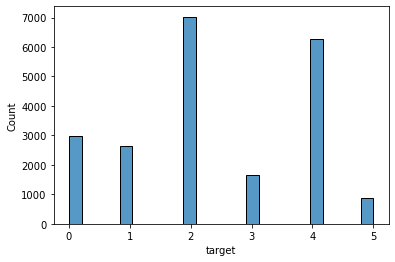

In [113]:
sns.histplot(df['target'])

In [114]:
url_re = re.compile(r'^https?://', re.IGNORECASE)

print(df.shape)

def is_url(word):
    return url_re.search(word) is not None


def keep_row(row):
    return not is_url(row['Text'])


df = df[df.apply(keep_row, axis=1)]

print(df.shape)

# No urls

(21459, 3)
(21459, 3)


In [115]:
from sklearn.model_selection import train_test_split

X = df['Text']
y = df.target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42) 

In [116]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(15450,)
(4292,)
(1717,)


### 2nd Dataset

In [139]:
twitter_df = pd.read_csv('../data/text_emotion.csv')

In [141]:
twitter_df = twitter_df.drop(['tweet_id', 'author'], axis=1)

In [150]:
df = df.rename(columns={"Emotion": "feelings", "Text": "content"})
twitter_df = twitter_df.rename(columns={"sentiment": "feelings"})

In [154]:
df.feelings.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [153]:
twitter_df.feelings.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [124]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
    
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [126]:
from tensorflow.keras import layers

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    max_tokens=max_features,
    output_sequence_length=sequence_length,
)

# Let's call `adapt`:
vectorize_layer.adapt(X_train)

In [136]:
# A integer input for vocab indices.
input = tf.keras.Input(shape=(1,), dtype='string')
x = vectorize_layer(input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = max_features, output_dim = embedding_dim, embeddings_initializer='uniform')(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling.
x = layers.Conv1D(128, 7, padding="same", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding="same", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
output = layers.Dense(6, activation="softmax", name="predictions")(x)

model = tf.keras.Model(input, output)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [137]:
epochs = 5
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs)

Epoch 1/5
483/483 [==============================] - 75s 145ms/step - loss: 1.4611 - acc: 0.4015 - val_loss: 1.1828 - val_acc: 0.5666
Epoch 2/5
483/483 [==============================] - 67s 139ms/step - loss: 0.9359 - acc: 0.6405 - val_loss: 0.6649 - val_acc: 0.7155
Epoch 3/5
483/483 [==============================] - 68s 142ms/step - loss: 0.5969 - acc: 0.7399 - val_loss: 0.5222 - val_acc: 0.7789
Epoch 4/5
483/483 [==============================] - 69s 142ms/step - loss: 0.4172 - acc: 0.8287 - val_loss: 0.3657 - val_acc: 0.8793
Epoch 5/5
483/483 [==============================] - 71s 146ms/step - loss: 0.2649 - acc: 0.9088 - val_loss: 0.3569 - val_acc: 0.8945


In [144]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 18s 45ms/step - loss: 0.3848 - acc: 0.8905
test loss, test acc: [0.38483569025993347, 0.8905066847801208]


In [145]:
print("Generate predictions for 30 samples")
predictions = model.predict(X_test[:30])
print("predictions shape:", predictions.shape)

Generate predictions for 30 samples
predictions shape: (30, 6)
